# Chapter 12. Custom Models and Training with TensorFlow

Most of the time, the Keras API will be as far as a user needs to go into TensorFlow.
However, there will be times when we want to make custom pieces for our model and will be required to have additional control by using the rest of TensorFlow.
This is what is covered below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import pathlib

# A path to the assets folder for this notebook.
assets_path = pathlib.Path("assets", "ch12")

# Set NumPy seed.
np.random.seed(0)

In [2]:
%matplotlib inline

In [3]:
%load_ext ipycache

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


## A quick tour of TensorFlow

The author provided a brief description of TensorFlow, elucidating its overall structure, and also pointing out some useful resources beyond the API (e.g. TensorFlow Hub and Extended (TFX)).

## Using TensorFlow like NumPy

TF is built around the flow of tensors from one operation to another.
Thus it is important to first understand how to use tensors before we can build custom pieces for TF.

### Tensors and operations

A tensor can be created using `tf.constant()`.
Below, a scalar is made and a 2x3 matrix is created.

In [4]:
# Scalar
tf.constant(42)

<tf.Tensor: id=0, shape=(), dtype=int32, numpy=42>

In [5]:
# 2x3 matrix
tf.constant([[1, 2, 3], [4, 5, 6]], dtype=tf.float32)

<tf.Tensor: id=1, shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [6]:
t = tf.constant([[1, 2, 3], [4, 5, 6]], dtype=tf.float32)
t.shape

TensorShape([2, 3])

In [7]:
t.dtype

tf.float32

Indexing in TF is similar to indexing in NumPy.

In [8]:
t[:, :1]

<tf.Tensor: id=6, shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [4.]], dtype=float32)>

In [9]:
t[..., 0:1]

<tf.Tensor: id=10, shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [4.]], dtype=float32)>

There are many tensor mathematical operations available.

In [10]:
# Addition.
t + 10

<tf.Tensor: id=12, shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [11]:
# Square each element.
tf.square(t)

<tf.Tensor: id=13, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [12]:
# Matrix multiplication (`@` was new in Python 3.5).
t @ tf.transpose(t)

<tf.Tensor: id=16, shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

Many of the function available from NumPy as available in TF, often with the same name.
However, there are times where the names differ, though it is usually because the operations are slightly different.

### Tensors and NumPy

Tensors "play nicely" with NumPy.
It is easy to convert between the two.

In [13]:
# From NumPy to TF.
a = np.array([2, 4, 5], dtype=np.float32)
tf.constant(a)

<tf.Tensor: id=17, shape=(3,), dtype=float32, numpy=array([2., 4., 5.], dtype=float32)>

In [14]:
# From TF to NumPy.
t = tf.constant([[1, 2, 3], [4, 5, 6]], dtype=tf.float32)
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [15]:
# Addition of NumPy and TF.
a + t

<tf.Tensor: id=20, shape=(2, 3), dtype=float32, numpy=
array([[ 3.,  6.,  8.],
       [ 6.,  9., 11.]], dtype=float32)>

### Type conversions

TF does not perform automatic type casting!
This is true even for different floating point precisions.
Instead, it always raises an exception.

In [16]:
# Throws an error.
# tf.constant(2.0, dtype=tf.float16) + tf.constant(2.0, dtype=tf.float32)

#> InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was 
#> expected to be a half tensor but is a float tensor [Op:AddV2] name: add/

The `tf.cast()` function can be used to change types.

In [17]:
a = tf.constant(2.0, dtype=tf.float16)
b = tf.constant(2.0, dtype=tf.float32)
a + tf.cast(b, a.dtype)

<tf.Tensor: id=24, shape=(), dtype=float16, numpy=4.0>

### Variables

TF's `Tensor` values are immutable.
The `Variable` type is mutable.
It behaves simillarly to `Tensor` with regards to mathematic operations and wokring with NumPy, though values can be assigned in place.

In [18]:
v = tf.Variable([[1, 2, 3], [4, 5, 6]], dtype=tf.float32)
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [19]:
v.assign(v * 2)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [20]:
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

Cells or slices can be assigned by calling the `assign()` method in the index.

In [21]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [22]:
v[:, 2].assign([-10.0, -20.0])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[  2.,  42., -10.],
       [  8.,  10., -20.]], dtype=float32)>

### Other data structures

Some other data types to be aware or are listed below with brief descriptions:

* **sparse tensors**: Tensors with many zeros. The `tf.sparse` library has many specific operations.
* **tensor arrays**: Lists of tensors of the same shape and data type.
* **ragged tensors**: List of lists of tensors of the same shape and data type. The `tf.ragged` library has many specific operations.
* **string tensors**: Regular tensors of type `tf.string`. The `tf.strings` library has many specific operations.
* **sets**: Regular or sparse tensors.  The `tf.sets` library has many specific operations.
* **queues**: A way of storing tensors across multiple steps. The `tf.queue` library has many specific operations.

## Customizing models and training algorithm

### Custom loss functions

In the following example, we implement the [Huber loss function]() (though it is available in already in `tf.keras`).
The first step is to define a function that takes the labels and predictions as arguments and use TF operations to compute every instance's loss.
The function should return a tensor with the loss for each instance.
It is important to use TF operations for two reasons: 1) they are vectorized, thus faster; 2) you still benefit from TF's graph optimization features.

In [23]:
def huber_loss_fxn(y_true, y_pred):
    """The Huber loss function for TF."""
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)


# Create a simple model.
model = keras.models.Sequential([
    keras.layers.InputLayer(5),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model for use with the custom loss function.
model.compile(loss=huber_loss_fxn, optimizer='nadam')

### Saving and loading models that constain custom components

Keras does not save the function when a model is saved, just the *name* of the function.
Thus a dictionary must be passed to map the name to the function.

In [24]:
model_path = assets_path.joinpath("model_with_custom_loss.h5")
model.save(model_path.as_posix())

custom_objects = {'huber_loss_fxn': huber_loss_fxn}

model = keras.models.load_model(model_path.as_posix(),
                                custom_objects=custom_objects)

Let's say, however, you wanted to include another parameter in the loss function.
For example, the current Huber loss function has a range of -1 to 1 for "small", but we want to let this be adjusted.
One way is to create a function factory to return a Huber loss function with a different threshold.
This parameter, though, will not be saved with the model and, thus, must be supplied when loading the model.

In [25]:
def create_huber_loss_fxn(threshold=1.0):
    def huber_loss_fxn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_loss_fxn


model.compile(loss=create_huber_loss_fxn(2.0), optimizer='nadam')

model.save(model_path.as_posix())

When the model is loaded in, the Huber loss function must be re-created with the same threshold.

In [26]:
custom_objects = {'huber_loss_fxn': create_huber_loss_fxn(2.0)}

model = keras.models.load_model(model_path.as_posix(),
                                custom_objects=custom_objects)

This implementation is non-ideal because it requires the user to remember and supply the threshold.
Thus, a better method is to subclass the `keras.losses.Loss` class and implement the `get_config()` method.
This method allows Keras to save and load the parameter to JSON with the rest of the model.

In [27]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}


model.compile(loss=HuberLoss(2.0), optimizer='nadam')

model.save(model_path.as_posix())

However, there seems to currently be a bug in loading models with custom loss classes.
Thus, loading the model does not work.

In [28]:
# model = keras.models.load_model(model_path.as_posix(),
#                                custom_objects={'HuberLoss': HuberLoss})

### Custom activation functions, initializers, regularizers, and constraints

A similar processes is required to create custom activation functions, initializers, regularizers, and constraints.
Generally, you just need to create a function with the correct inputs and outputs.
Here are some examples followed by a layer using them.

In [29]:
def my_softplus_activation_fxn(z):
    return tf.math.log(tf.exp(z) + 1.0)


def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2.0 / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)


def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))


def my_positive_weights_constraint(weights):
    return tf.where(weights < 0.0, tf.zeros_like(weights), weights)


keras.layers.Dense(units=30,
                   activation=my_softplus_activation_fxn,
                   kernel_initializer=my_glorot_initializer,
                   kernel_regularizer=my_l1_regularizer,
                   kernel_constraint=my_positive_weights_constraint)

If additional hyperparameters must be retained by the saved model, then you will have to subclass the appropriate TF class like shown previously.
*Remember to implement the `get_config()` method.*

### Custom metrics

The most basic custom metric is a function that takes two parameters, `y_true` and `y_pred`, and computes the metric given that information.
This function is called at each training batch and TF keeps a running average of the results.

Sometimes, however, we want to retain the previous values and accumulate the results, ourselves.
This is coming for *streaming metrics* (or *stateful metrics*, those that are continuously updated over the training.
One example is precision.
To do this, we create a `keras.metrics.Precision` object and pass it the the real and predicted values.

In [30]:
precision = keras.metrics.Precision()

# Mock two training steps.
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

precision.result()

<tf.Tensor: id=737, shape=(), dtype=float32, numpy=0.5>

In [31]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

The values can be reset using the `reset_states()` method.

In [32]:
precision.reset_states()

If you need to create a custom streaming method, subclass `keras.metrics.Metric`.
Below is an example of implementing a custom streaming metric that tracks the Huber loss and number of instances seen so far.
Further, when asked for a result, it returns the ratio.

In [33]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.huber_fn = create_huber_loss_fxn(threshold)
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.total / self.count
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

Here are some notes on the above class:

* The constructor uses the `add_weight()` method to create the variables to keep track of the desired information over the training batches. Alternatively, you could just create a `tf.Variable` for each and TF will automatically remember it.
* The `update_state()` is called when the object of the class gets called as a function. It is provided the real and predicted labels and batch weights (ignored in the example).
* The `result()` method returns the desired result.
* The `get_config()` method helps to remember any hyperparameters, used here to remember the threshold for the Huber loss.
* There is also a `reset_states()` method that, by default, resets all variables, though it can be overriden if desired.

### Custom layers

There are two common circumstances under which a custom layer is desireable. The first is if you want to implement a new layer architecture that isn't available in Keras. The second is if you have a identical blocks of layers that you don't want to repeat over and over. For instance, if you wanted to have a pattern a layers $\text{ABCABCABC}$, then you could create a layer $\text{D = ABC}$ and make a network $\text{DDD}$, instead.
The following are several ways to create a custom layer.

Some layers do not have any weights such as `Flatten` or `ReLU`.
If you want a layer without any weights, the easiest option is to create a `Lambda` layer and and provide it a function to use to transform its inputs.
Here is an example of an exponential layer.

In [34]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

To create a *stateful layer*, a layer with weights, create a subclass of the `Layer` class.
Below is an example reimplementing a Dense layer.

In [35]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=[batch_input_shape[-1], self.units],
                                      initializer='glorot_normal')
        self.bias = self.add_weight(name='bias',
                                    shape=[self.units],
                                    initializer='zeros')
        super().build(batch_input_shape)

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                'units': self.units,
                'activation': keras.activations.serialize(self.activation)}

The following are notes on the above class:

* The constructor method takes all of the hyperparameters as arguments and creates the necessary attributes. The parent constructor takes care of the standard information and the rest is customizable.
* The `build()` method creates the layers variables by calling `add_weight()`. This will be called when the layer is first used because only then will it know the number of connections to make. *Remember to call the parent `build()` method at the end.*
* The `call()` method performs the desired neuron function. In this case, it is a simple linear formula passed to the activation function.
* The `compute_output_shape()` method returns a tensor of the shape of the outputs of the layer. This method can often be ignored in TF Keras because it is automatically inferred. This does not apply to dynamic layers.
* The `get_config()` method is used to help Keras store and retrieve custom hyperparameters.

If the layer takes multiple inputs, such as `Concatenate`, the arguments to `call()` and `compute_output_shape()` will be tuples of the inputs and input's batch shape, respectively.
Below is a toy example of a layer that takes two inputs and returns three outputs.

In [36]:
class MyToyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return [X1 + X2, X1 * X2, X1 / X2]
    
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1]

If the layer must behave differently between training and testing, then a `training` argument must be added to `call()`.
It will be passed a boolean or `None` to indicate the if the model is in training or not.

In [37]:
class MyGaussianNoiseLayer(keras.layers.Layer):
    def __init__(self, stddev=1, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
    
    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X
        
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

### Custom models

As an example of the flexibility and power provided by TF, we will create the following custom model:

1. A Dense input layer.
2. A Residual Block composed of two Dense layers and an addition operator. The input data flows through the two Dense layers and the input data is again added to the output data which is then fed back through the residual block. This procedure is repeated three times.
3. Another Residual Block.
4. A Dense output layer.

To begin, we will create a custom layer for the Residual Block.

In [38]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons,
                                          activation='elu',
                                          kernel_initializer='he_normal')
                       for _ in range(n_layers)]

    def call(self, X, training=None):
        Z = X
        for layer in self.hidden:
            Z = layer(Z)
        return X + Z

    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                'n_layers': n_layers,
                'n_neurons': n_neurons}

Now we can use the Subclassing API to create the model.

In [39]:
class ResidualRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30,
                                          activation='elu',
                                          kernel_initializer='he_normal')
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, X):
        Z = self.hidden1(X)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                'output_dim': output_dim}

The model can now be trained and used like any other.
The `get_config()` methods for `ResidualBlock` and `ResidualRegressor` were implemented, so the model could be saved and loaded.

### Losses and metrics based on model internals

Previously, we created custom loss functions that accept the predicted values, the known values, and a binary training argument.
However, there are times we want to use additional information about the model to compute a specific loss function.
For example, we can design a regression model with a *reconstruction loss* that computes the mean squared difference between the original inputs and the reconstructed outputs (we did a similar thing when studying decomposition and dimensionality reduction).
To apply the custom loss, the reconstruction loss is computed and added to the normal MSE loss using the `add_loss()` method within the `call()` method.

In [40]:
class ReconstructionRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(units=30, 
                                          activation='selu', 
                                          kernel_initializer='lecun_normal')
                      for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
    
    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        # An additional output layer for the reconstruction.
        self.reconstruct = keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)
    
    def call(self, X):
        Z = X
        for layer in self.hidden:
            Z = layer(Z)
        
        # Apply reconstruction loss.
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        
        return self.out(Z)

A custom metric is created in a similar fashion.
The result must be a `keras.metrics` object and added to the others using the `add_metric()` method.
A new copy of `ReconstructionRegressor` is created below with this feature.

In [41]:
class ReconstructionRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(units=10,
                                          activation='relu')
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)

    def build(self, batch_input_shape):
        self.reconstruct_layer = keras.layers.Dense(batch_input_shape[-1])
        super().build(batch_input_shape)

    def call(self, X):
        Z = X
        for layer in self.hidden:
            Z = layer(Z)

        # Include reconstruction loss.
        reconstruction = self.reconstruct_layer(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - X))
        self.add_loss(0.05 * recon_loss)
        
        # Report reconstruction loss as a metric.
        # self.recon_metric.update_state(recon_loss)
        # self.add_metric(self.recon_metric, name='reconstruction_loss')

        return self.out(Z)

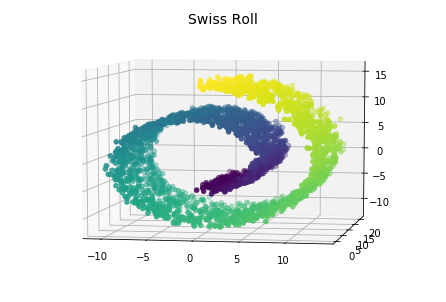

In [42]:
from sklearn.datasets import make_swiss_roll
import mpl_toolkits.mplot3d.axes3d as p3

X, y = make_swiss_roll(3000, noise=0.3, random_state=0)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)
plt.title("Swiss Roll", fontsize=14)
plt.show()

In [45]:
model = ReconstructionRegressor(1)
model.compile(loss='mse', 
              optimizer='nadam')
model.fit(X, y, epochs=20, validation_split=0.2)

Train on 2400 samples, validate on 600 samples
Epoch 1/20
2400/2400 [==============================] - 3s 1ms/sample - loss: 49.5501 - val_loss: 15.0125
Epoch 2/20
2400/2400 [==============================] - 0s 157us/sample - loss: 6.6965 - val_loss: 4.5870
Epoch 3/20
2400/2400 [==============================] - 0s 159us/sample - loss: 3.7183 - val_loss: 3.1629
Epoch 4/20
2400/2400 [==============================] - 0s 163us/sample - loss: 2.6642 - val_loss: 2.4296
Epoch 5/20
2400/2400 [==============================] - 0s 171us/sample - loss: 2.1406 - val_loss: 1.9774
Epoch 6/20
2400/2400 [==============================] - 0s 174us/sample - loss: 1.8015 - val_loss: 1.6936
Epoch 7/20
2400/2400 [==============================] - 0s 179us/sample - loss: 1.5154 - val_loss: 1.4168
Epoch 8/20
2400/2400 [==============================] - 0s 148us/sample - loss: 1.2558 - val_loss: 1.1654
Epoch 9/20
2400/2400 [==============================] - 0s 143us/sample - loss: 1.0413 - val_loss: 0.9741

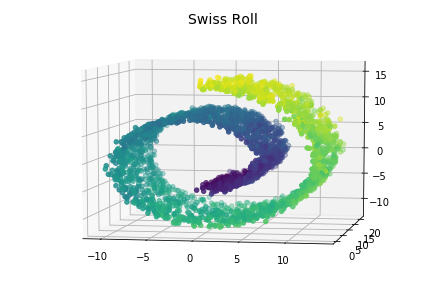

In [46]:
y_pred = model.predict(X)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred.ravel())
plt.title("Swiss Roll", fontsize=14)
plt.show()